In [266]:
import numpy as np, pandas as pd, os, sys
from sklearn.datasets import fetch_mldata
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, f1_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.base import BaseEstimator, clone

In [267]:
from sklearn.datasets.base import get_data_home 
#print (get_data_home())

In [268]:
%matplotlib inline
import matplotlib , matplotlib.pyplot as plt

In [269]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8)
np.random.seed(1)
rand_digit = np.random.choice(np.arange(len(mnist)))

In [270]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

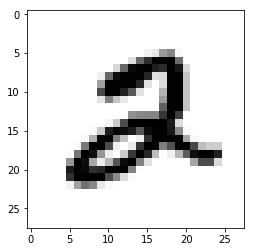

In [271]:
dig_img = X[rand_digit].reshape(28,28)
plt.imshow(dig_img, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.show()

In [272]:
print (f'Number on the picture is {y[rand_digit]}')

Number on the picture is 2


In [273]:
unique, counts = np.unique(y, return_counts=True)
print ('Unique number in dataset and their counts')
dict(zip(unique, counts))

Unique number in dataset and their counts


{0: 6903,
 1: 7877,
 2: 6990,
 3: 7141,
 4: 6824,
 5: 6313,
 6: 6876,
 7: 7293,
 8: 6825,
 9: 6958}

In [274]:
train_index = np.random.permutation(int(len(X) * 0.75))
mask1 = ~np.isin(list(np.arange(len(X) )), train_index)
test_index = np.arange(len(X))[mask1]
X_train, y_train, X_test1, y_test1 = X[train_index], y[train_index], X[test_index], y[test_index]

In [275]:
X_train.shape, y_train.shape, X_test1.shape, y_test1.shape

((52500, 784), (52500,), (17500, 784), (17500,))

### Random Forest

In [276]:
rf_clf = RandomForestClassifier(random_state=1)
rf_clf.fit(X_train, y_train)
y_test_pred = rf_clf.predict(X_test1)
y_train_pred = rf_clf.predict(X_train)

/home/sedovda/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Answer = 1, prediction is 1


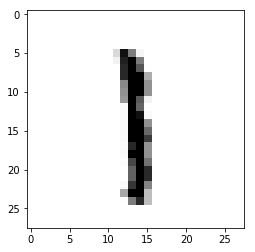

In [277]:
n=543
print (f'Answer = {y_train[n]}, prediction is {y_train_pred[n]}')
dig_img = X_train[n].reshape(28,28)
plt.imshow(dig_img, cmap = matplotlib.cm.binary, interpolation='nearest')
plt.show()

In [279]:
precision = precision_score(y_test1, y_test_pred, average='micro')
accuracy_train = np.sum(y_train == y_train_pred)/len(y_train)
accuracy_test = np.sum(y_test1 == y_test_pred)/len(y_test1)
print (f'train_acc = {accuracy_train}, test_acc = {accuracy_test}')

train_acc = 0.9991238095238095, test_acc = 0.9511428571428572


In [281]:
#Most common errors of the forest
result = pd.DataFrame()
result['y'] = y_test1
result['y_pred'] = y_test_pred
result['hit'] = result[['y_pred' , 'y']].apply(lambda r: r[1]==r[0], axis = 1)
result[result.y_pred != result.y].pivot_table(index='y_pred', columns='y', aggfunc = 'count')

hit                                                     
y         0    1     2     3     4     5     6     7     8     9
y_pred                                                          
0       NaN  NaN  12.0   6.0   3.0  12.0  12.0   1.0   9.0  11.0
1       1.0  NaN   3.0   2.0   8.0   1.0   2.0   7.0  10.0   8.0
2       3.0  5.0   NaN  29.0   7.0   9.0   2.0  31.0  23.0  11.0
3       2.0  9.0  12.0   NaN   4.0  60.0   3.0   8.0  36.0  17.0
4       2.0  1.0   5.0   1.0   NaN   9.0   6.0  12.0  11.0  42.0
5       2.0  3.0   1.0  35.0   3.0   NaN  10.0   1.0  16.0  10.0
6       6.0  4.0   7.0   1.0   7.0  16.0   NaN   1.0  17.0   2.0
7       2.0  2.0  15.0  14.0   3.0   4.0   NaN   NaN   8.0  19.0
8       6.0  5.0  15.0  26.0   7.0  12.0   5.0   6.0   NaN  12.0
9       2.0  NaN   NaN   2.0  34.0   5.0   NaN  23.0  18.0   NaN

In [60]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

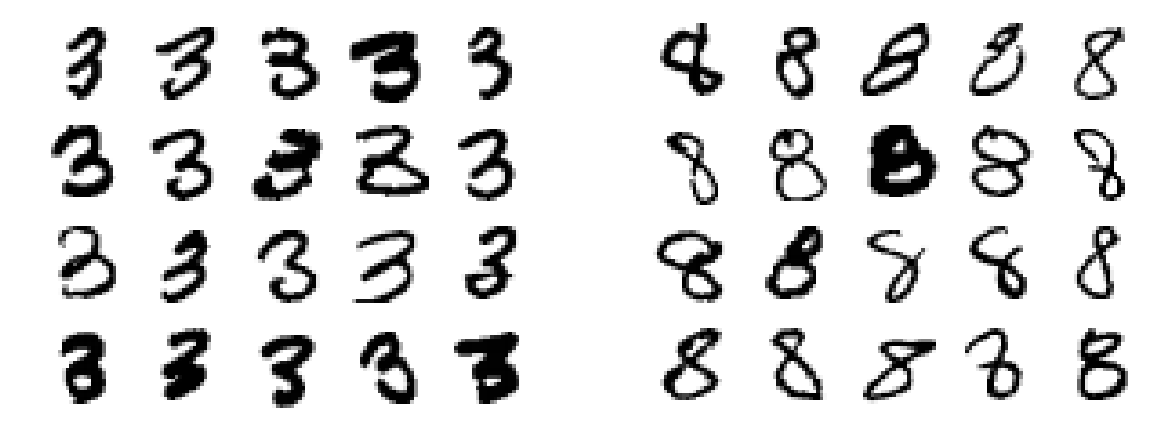

In [284]:
n1, n2 = 3,8
X_ab = X_test1[(y_test1 == n1) & (y_test_pred == n2)]
X_ba = X_test1[(y_test1 == n2) & (y_test_pred == n1)]
plt.figure(figsize=(20,20))
plt.subplot(121); plot_digits(X_ab[0:20], images_per_row = 5)
plt.subplot(122); plot_digits(X_ba[0:20], images_per_row = 5)


plt.show()

# adding more images to dataset via moving current images for 1 pixel each side

In [285]:
def move_number(X,y, w,h):
    """
    Takes reshaped array for single number
    w-width
    h-height
    """
    # reshape start #
    X = X.reshape(h,w)
    # reshape end #
    Xup = np.concatenate((X, np.zeros((1,X.shape[1]), dtype = 'int8')), axis = 0)
    Xdown = np.concatenate((np.zeros((1,X.shape[1]), dtype = 'int8'), X), axis = 0)
    Xleft = np.concatenate((X, np.zeros((1,X.shape[0]), dtype = 'int8').T), axis = 1)
    Xright = np.concatenate((np.zeros((1,X.shape[0]), dtype = 'int8').T, X), axis = 1)
    up = Xup[1:, :].reshape(1,h*w)
    down = Xdown[:-1,:].reshape(1,h*w)
    left = Xleft[:, 1:].reshape(1,h*w)
    right = Xright[:, :-1].reshape(1,h*w)
    allX = np.concatenate((up, down, left, right), axis = 0)
    return np.concatenate((allX, np.array([y,y,y,y]).reshape((1,4)).T), axis = 1)
move_number(X_train[10], y_train[10], 28,28)

array([[0., 0., 0., ..., 0., 0., 2.],
       [0., 0., 0., ..., 0., 0., 2.],
       [0., 0., 0., ..., 0., 0., 2.],
       [0., 0., 0., ..., 0., 0., 2.]])

In [286]:
def gather_dataset(X, y):
    L=[]
    for i, row in enumerate(X):
        a = move_number(X[i],y[i], 28, 28)
        L.append(a)
    return np.concatenate(tuple(L), axis = 0)

In [287]:
dataset = gather_dataset(X, y)

In [288]:
X1, y1 = dataset[:, :-1], dataset[:,-1:]
y1 = y1.reshape(len(X1))

### RandomForest with 4x dataset

In [289]:
train_index = np.random.permutation(int(len(X1) * 0.75))
mask1 = ~np.isin(list(np.arange(len(X1) )), train_index)
test_index = np.arange(len(X1))[mask1]
X_train, y_train, X_test, y_test = X1[train_index], y1[train_index], X1[test_index], y1[test_index]

rf_clf = RandomForestClassifier(random_state=2)
rf_clf.fit(X_train, y_train)
y_test_pred = rf_clf.predict(X_test)
y_train_pred = rf_clf.predict(X_train)

/home/sedovda/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [290]:
precision = precision_score(y_test, y_test_pred, average='micro')
accuracy_train = np.sum(y_train == y_train_pred)/len(y_train)
accuracy_test = np.sum(y_test == y_test_pred)/len(y_test)
print (f'train_acc = {accuracy_train}, test_acc = {accuracy_test}')

train_acc = 0.9992142857142857, test_acc = 0.9528


Answer = 4.0, prediction is 4.0


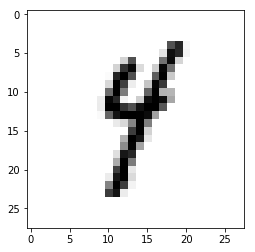

In [291]:
n=5190
print (f'Answer = {y_train[n]}, prediction is {y_train_pred[n]}')
dig_img = X_train[n].reshape(28,28)
plt.imshow(dig_img, cmap = matplotlib.cm.binary, interpolation='nearest')
plt.show()

### Comparison with KNN

In [234]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
           weights='distance')

In [259]:
%%time
y_test_knn = knn_clf.predict(X_test1)


CPU times: user 2h 28min 37s, sys: 4.45 s, total: 2h 28min 41s
Wall time: 37min 46s


In [265]:
accuracy_test = np.sum(y_test1 == y_test_knn)/len(y_test1)
print (f'Accuracy with KNN = {round(accuracy_test,3)}')

Accuracy with KNN = 0.975
